Importing from libraries:

In [10]:
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import time

import torch
import tqdm
from torch import nn
from torch.nn import functional as F
from torchvision import transforms as T
from torchvision.transforms import functional as TF
from torchvision.transforms.functional import InterpolationMode
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import VOCSegmentation
from torchvision import models
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

Imports from my code:

In [11]:
from slicing import *
from tools import *
from create_mask import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights

DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1.transforms()

SemanticSegmentation(
    resize_size=[520]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Setting seed:

In [13]:
torch.manual_seed(24)
np.random.seed(24)

We need to remove maximum image pixels limit in Image module because we are working with high resolution images:

In [14]:
Image.MAX_IMAGE_PIXELS = None

In [15]:
images_path = Path('dataset/images')
masks_path = Path('dataset/masks')

Flattening directories in images dataset:

In [16]:
flatten_folder(images_path)

creating masks from vpa files:

In [18]:
corrupted_masks = []
with tqdm.tqdm(os.listdir(images_path), total=len(os.listdir(images_path))) as pbar:
    for image_name in pbar:
        image_path = images_path / image_name
        mask_path = masks_path / f'{image_path.stem}.vpa'
        mask_image_name = f'{image_path.stem}.jpg'
        mask_image_path = masks_path / mask_image_name
        if mask_image_path.exists():
            continue
        if not mask_path.exists():
            # no cancer
            mask = create_empty_mask(image_path)
        else:
            try:
                mask = create_mask_from_vpa(image_path, mask_path)
            except Exception as e:
                print(f'Error creating mask from {mask_path.name}: {str(e)}')
                corrupted_masks.append(image_name)
                continue
        try:
            mask.save(masks_path / mask_image_name)
        except Exception as e:
            print(f'Error saving mask {mask_path.name}: {str(e)}')
            corrupted_masks.append(image_name)

100%|██████████| 110/110 [00:00<00:00, 18265.70it/s]


Testing slices on a image:

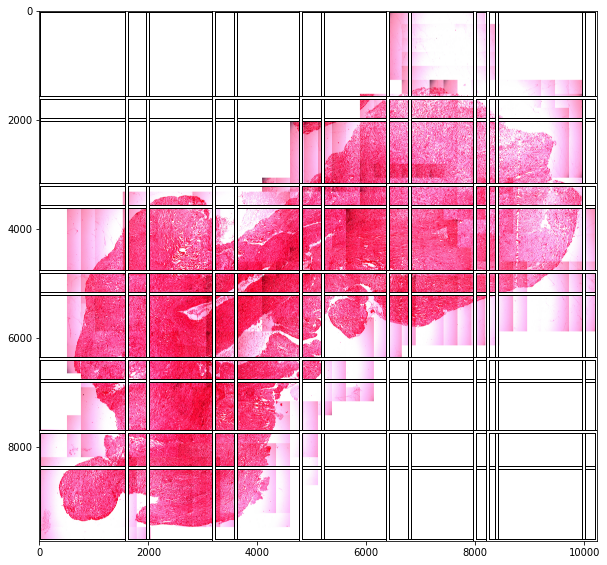

In [19]:
img = Image.open(images_path / '96-6433-2-20X-0.50 ph1__UPlanF1__Olympus----M1.jpg')
bboxs = calculate_slices(img.size, (2000, 2000))
show_image(img, bboxs)

Gathering name and size of images in images directory:

In [21]:
dataset_images = []
for image_name in set(os.listdir(images_path)).difference(corrupted_masks):
    img_path = images_path / image_name
    # skipping images without mask
    mask_name = f'{img_path.stem}.jpg'
    mask_path = masks_path / mask_name
    if not mask_path.exists():
        continue
    img = Image.open(img_path)
    w, h = img.size
    dataset_images.append({'image_name': image_name, 'w': w, 'h': h})

In [22]:
dataset_df = pd.DataFrame(dataset_images)
dataset_df.head()

,image_name,w,h
0,96-T----1--2548--20X-0.50 ph1__UPlanF1__Olympu...,19456,17152
1,96-6433-2M-20X-0.50 ph1__UPlanF1__Olympus----R...,14080,9472
2,96-6433-2-20X-0.50 ph1__UPlanF1__Olympus----LD...,10240,12032
3,96-T----1--2548--20X-0.50 ph1__UPlanF1__Olympu...,49664,41984
4,96-T-12-10608-20X-0.50 ph1__UPlanF1__Olympus-2...,13056,42496


In [23]:
image_name_to_id = {v: i for i, v in enumerate(dataset_df.image_name.unique())}
image_id_to_name = {i: v for i, v in enumerate(dataset_df.image_name.unique())}

In [24]:
dataset_df['image_id'] = dataset_df.image_name.apply(lambda x: image_name_to_id[x])
dataset_df.head()

,image_name,w,h,image_id
0,96-T----1--2548--20X-0.50 ph1__UPlanF1__Olympu...,19456,17152,0
1,96-6433-2M-20X-0.50 ph1__UPlanF1__Olympus----R...,14080,9472,1
2,96-6433-2-20X-0.50 ph1__UPlanF1__Olympus----LD...,10240,12032,2
3,96-T----1--2548--20X-0.50 ph1__UPlanF1__Olympu...,49664,41984,3
4,96-T-12-10608-20X-0.50 ph1__UPlanF1__Olympus-2...,13056,42496,4


In [25]:
slices_width = 512
slices_height = 512
overlap_width_ratio = 0.2
overlap_height_ratio = 0.2

In [26]:
dataset_df['slices'] = dataset_df.apply(
    lambda row: calculate_slices((row['w'], row['h']), (slices_width, slices_height),
                                 overlap_width_ratio, overlap_height_ratio), axis=1)
dataset_df.head()

,image_name,w,h,image_id,slices
0,96-T----1--2548--20X-0.50 ph1__UPlanF1__Olympu...,19456,17152,0,"[[0, 0, 512, 512], [410, 0, 922, 512], [820, 0..."
1,96-6433-2M-20X-0.50 ph1__UPlanF1__Olympus----R...,14080,9472,1,"[[0, 0, 512, 512], [410, 0, 922, 512], [820, 0..."
2,96-6433-2-20X-0.50 ph1__UPlanF1__Olympus----LD...,10240,12032,2,"[[0, 0, 512, 512], [410, 0, 922, 512], [820, 0..."
3,96-T----1--2548--20X-0.50 ph1__UPlanF1__Olympu...,49664,41984,3,"[[0, 0, 512, 512], [410, 0, 922, 512], [820, 0..."
4,96-T-12-10608-20X-0.50 ph1__UPlanF1__Olympus-2...,13056,42496,4,"[[0, 0, 512, 512], [410, 0, 922, 512], [820, 0..."


In [27]:
dataset_df = dataset_df.drop(columns=['image_name'], errors='ignore')
dataset_df = dataset_df.explode(column='slices', ignore_index=True)
dataset_df.head()

,w,h,image_id,slices
0,19456,17152,0,"[0, 0, 512, 512]"
1,19456,17152,0,"[410, 0, 922, 512]"
2,19456,17152,0,"[820, 0, 1332, 512]"
3,19456,17152,0,"[1230, 0, 1742, 512]"
4,19456,17152,0,"[1640, 0, 2152, 512]"


In [28]:
dataset_df = pd.merge(dataset_df, pd.DataFrame(dataset_df.slices.to_list(), columns=['xmin', 'ymin', 'xmax', 'ymax']),
                      left_index=True, right_index=True)
dataset_df.head()

,w,h,image_id,slices,xmin,ymin,xmax,ymax
0,19456,17152,0,"[0, 0, 512, 512]",0,0,512,512
1,19456,17152,0,"[410, 0, 922, 512]",410,0,922,512
2,19456,17152,0,"[820, 0, 1332, 512]",820,0,1332,512
3,19456,17152,0,"[1230, 0, 1742, 512]",1230,0,1742,512
4,19456,17152,0,"[1640, 0, 2152, 512]",1640,0,2152,512


Final DataFrame of our slices:

In [29]:
dataset_df = dataset_df[['image_id', 'w', 'h', 'xmin', 'ymin', 'xmax', 'ymax']]
dataset_df.head()

,image_id,w,h,xmin,ymin,xmax,ymax
0,0,19456,17152,0,0,512,512
1,0,19456,17152,410,0,922,512
2,0,19456,17152,820,0,1332,512
3,0,19456,17152,1230,0,1742,512
4,0,19456,17152,1640,0,2152,512


In [41]:
class CancerDataset(Dataset):
    def __init__(self, images_path: Path, masks_path: Path, slices_dataframe: pd.DataFrame, image_id_to_name: dict,
                 transformers=None, image_transformer=None, target_transformer=None, to_tensor=True):
        image_transformers = [image_transformer] if image_transformer is not None else []
        target_transformers = [target_transformer] if target_transformer is not None else []
        if to_tensor:
            image_transformers.append(T.ToTensor())
            target_transformers.append(T.ToTensor())
        self.image_transformer = T.Compose(image_transformers)
        self.target_transformer = T.Compose(target_transformers)
        self.transformers = transformers
        self.image_id_to_name = image_id_to_name
        self.slices_dataframe = slices_dataframe
        self.masks_path = masks_path
        self.images_path = images_path
        Image.MAX_IMAGE_PIXELS = None

    def __len__(self):
        return len(self.slices_dataframe)

    def __getitem__(self, index):
        slice = self.slices_dataframe.iloc[index]
        image_id, w, h, xmin, ymin, xmax, ymax = slice['image_id'], slice['w'], slice['h'], slice['xmin'], slice[
            'ymin'], slice['xmax'], slice['ymax']
        image_name = self.image_id_to_name[image_id]
        image_path = self.images_path / image_name
        image = Image.open(image_path)
        mask_path = f'{self.masks_path / image_path.stem}.jpg'
        mask = Image.open(mask_path)

        # crop image:
        image = image.crop((xmin, ymin, xmax, ymax))
        mask = mask.crop((xmin, ymin, xmax, ymax))

        # transforms:
        image = self.image_transformer(image)
        mask = self.target_transformer(mask)

        return image, mask

In [42]:
dataset = CancerDataset(images_path, masks_path, dataset_df, image_id_to_name)

Saving dataset object in file:

In [43]:
import pickle

with open('resources/dataset.pickle', 'wb') as file:
    pickle.dump(dataset, file)

In [44]:
# read dataset object from file:
with open('resources/dataset.pickle', 'rb') as file:
    dataset = pickle.load(file)

In [45]:
dataset[100][0]

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [46]:
# splitting train and test sets
voc_len = len(dataset)
train_len = int(0.8 * voc_len)
test_len = voc_len - train_len
train_set, test_set = random_split(dataset, [train_len, test_len])

In [47]:
# splitting train and val sets
train_len = int(0.8 * len(train_set))
val_len = len(train_set) - train_len
train_set, val_set = random_split(train_set, [train_len, val_len])

In [48]:
train_loader = DataLoader(train_set, 64, shuffle=True)
val_loader = DataLoader(val_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

In [50]:
model = models.segmentation.deeplabv3_resnet101(pretrained=False)
# model.classifier = DeepLabHead(2048, num_class)

C:\Users\MR.co\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\MR.co\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to C:\Users\MR.co/.cache\torch\hub\checkpoints\resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
import time, tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import time, tqdm


def train(model, train_loader, criterion, optimizer, epoch):
    train_loss = 0
    N_train = len(train_loader.dataset)

    model.train()
    with tqdm.tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
        for i, (x, y) in pbar:
            optimizer.zero_grad()

            x = x.to(device)
            y = y.to(device)
            p = model(x)

            loss = criterion(p, y)
            train_loss += loss.item() * len(x)

            pbar.set_description(f'Epoch:{epoch}, Train Loss: {train_loss / N_train:.3e}')

            loss.backward()
            optimizer.step()

    train_loss /= N_train
    return train_loss


def validate(model, val_loader, criterion, epoch=0, metrics=None):
    val_loss = 0
    N_val = len(val_loader.dataset)
    Y = []
    Y_pred = []
    model.eval()
    with torch.no_grad(), tqdm.tqdm(enumerate(val_loader), total=len(val_loader)) as pbar:
        for i, (x, y) in pbar:
            x = x.to(device)
            y = y.to(device)
            p = model(x)
            y_pred = p.argmax(dim=-1)
            loss = criterion(p, y)
            val_loss += loss.item() * len(x)

            pbar.set_description(f'Epoch:{epoch}, Val Loss: {val_loss / N_val:.3e}')
            Y.append(y.cpu().numpy())
            Y_pred.append(y_pred.cpu().numpy())
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    val_loss /= N_val
    result = {'loss': val_loss}
    if metrics is not None:
        result.update({metric: metric_func(Y, Y_pred) for metric, metric_func in metrics.items()})
    return result

In [ ]:
train_losses, val_losses = list(), list()

In [ ]:
def train_model(model, criterion, dataloaders, optimizer, num_epochs,
                model_name='pytorch_model', validation_metrics=None,
                scheduler=None):
    val = len(dataloaders) == 2
    if val:
        train_loader, val_loader = dataloaders
    else:
        train_loader, = dataloaders

    if validation_metrics is None:
        validation_metrics = dict()

    metrics_history = {metric: [] for metric in validation_metrics}
    val_loss_min = np.inf

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, epoch)
        train_losses.append(train_loss)
        if val:
            result = validate(model, val_loader, criterion, epoch, metrics=validation_metrics)
            val_loss = result['loss']
            val_losses.append(val_loss)
            for metric, metric_history in metrics_history:
                metric_history.append(result[metric])

            if val_loss <= val_loss_min:
                torch.save(model.state_dict(), f'{model_name}.pt')
                val_loss_min = val_loss
        if scheduler is not None:
            scheduler.step(val_loss)
        print('\n', '---' * 20)
    plt.plot(train_losses, label='train')
    if val:
        # load best model during different epochs
        model.load_state_dict(torch.load(f'{model_name}.pt'))
        plt.plot(val_losses, label='val')
        if len(metrics_history):
            plt.legend()
            plt.show()
            for metric, metric_history in metrics_history:
                plt.plot(metric_history, label=metric)
    plt.legend()
    plt.show()

    return model

In [ ]:
freeze_weights = False
model = model.to(device)
if freeze_weights:
    for param in model.parameters():
        param.requires_grad = False
    for param in model.classifier.parameters():
        param.requires_grad = True

In [ ]:
weighted_loss = False
if weighted_loss:
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(dataset.label_weights.sort_index().tolist())).to(device)
else:
    criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
lr = 1e-3
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=4, verbose=True)

In [ ]:
model = train_model(model, criterion, [train_loader, val_loader], optimizer, 25, 'cancer-segmentation', scheduler=scheduler);

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

average_policy = 'macro'
metrics = {'accuracy': accuracy_score, 'precision': lambda y1, y2: precision_score(y1, y2, average=average_policy),
           'recall': lambda y1, y2: recall_score(y1, y2, average=average_policy),
           'f1': lambda y1, y2: f1_score(y1, y2, average=average_policy),
           'confusion_matrix': confusion_matrix}

In [ ]:
test_results = validate(model, test_loader, criterion, metrics=metrics)
disp = ConfusionMatrixDisplay(test_results.pop('confusion_matrix'), display_labels=dataset.label_names)
disp.plot()
test_results

In [ ]:
# on training set:
train_results = validate(model, train_loader, criterion, metrics=metrics)
disp = ConfusionMatrixDisplay(train_results.pop('confusion_matrix'), display_labels=dataset.label_names)
disp.plot()
train_results

In [ ]:
# on val set:
val_results = validate(model, val_loader, criterion, metrics=metrics)
disp = ConfusionMatrixDisplay(val_results.pop('confusion_matrix'), display_labels=dataset.label_names)
disp.plot()
val_results